In [220]:
import pennylane as qml
from pennylane import numpy as np

Circuit

In [221]:
n_wires = 4
dev = qml.device("default.qubit", wires=n_wires)

In [222]:
n_angles_qubit = 3
def layer(W):

    n_wires = len(W)

    # rotate differently each qubit (each rotation needs 3 parameters)
    for i in range(n_wires):
        qml.Rot(W[i, 0], W[i, 1], W[i, 2], wires=i)

    # entangle qubits: qubits 0 and 1 are entangled with CNOT, qubits 2 and 3 are entangled with CNOT, ..., qubits n_wires-1 and 0 are entangled with CNOT
    for i in range(n_wires):
        qml.CNOT(wires=[i, (i+1)%n_wires])

In [223]:
# n_angles_qubit = 3
# def layer(W):

#     n_wires = len(W)

#     # rotate differently each qubit (each rotation needs 3 parameters)
#     for i in range(n_wires):
#         qml.Rot(W[i, 0], W[i, 1], W[i, 2], wires=i)

#     #CNOTs between all qubits
#     for i in range(n_wires):
#         for j in range(i+1,n_wires):
#             qml.CNOT(wires=[i,j])

#     # # rotate differently each qubit (each rotation needs 3 parameters)
#     # for i in range(n_wires):
#     #     qml.Rot(W[i, 3], W[i, 4], W[i, 5], wires=i)

#     #CNOTs between all qubits (now reversed)
#     for i in range(n_wires):
#         for j in range(i+1,n_wires):
#             qml.CNOT(wires=[j,i])


In [224]:
def statepreparation(angles):
    # qml.AngleEmbedding(features=angles, wires=range(n_wires), rotation='X')
    qml.BasisState(angles, wires=[0, 1, 2, 3])


In [225]:
@qml.qnode(dev, interface="autograd")
def circuit(weights, angles_i):

    statepreparation(angles_i)

    for W in weights:
        layer(W)

    return qml.expval(qml.PauliZ(0))

In [226]:
# we have 19 possible angles
possible_angles = np.linspace(0, 2*np.pi, 19)

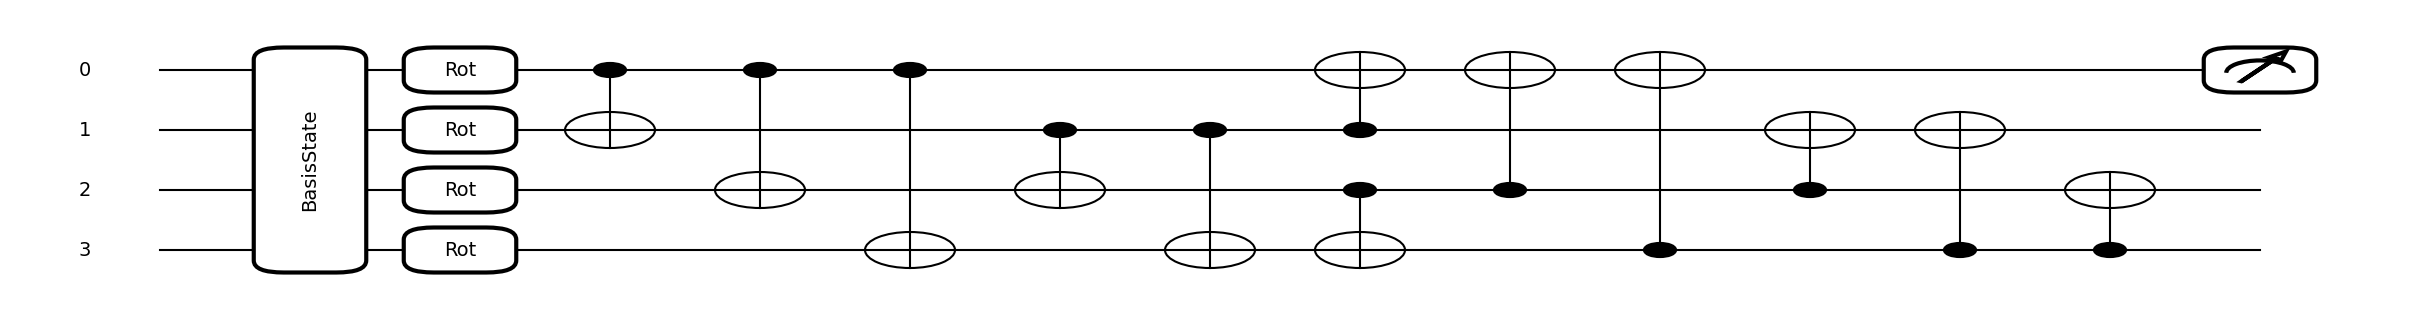

In [227]:
qml.drawer.use_style("black_white")

weights = 0.01 * np.random.randn(1, n_wires, 6, requires_grad=True)
# choose n_wires random angles from possible_angles
angles_i = np.random.choice(possible_angles, size=n_wires)

fig, ax = qml.draw_mpl(circuit, expansion_strategy="device")(weights, angles_i)
fig.set_size_inches((24, 3))

In [228]:
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

Cost

In [229]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

In [230]:
def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

In [231]:
def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

Optimization

In [232]:
data = np.loadtxt("data/parity.txt")
X = np.array(data[:, :-1], requires_grad=False)
Y = np.array(data[:, -1], requires_grad=False)
Y = Y * 2 - np.ones(len(Y))  # shift label from {0, 1} to {-1, 1}

for i in range(5):
    print("X = {}, Y = {: d}".format(X[i], int(Y[i])))

print("...")

X = [0. 0. 0. 0.], Y = -1
X = [0. 0. 0. 1.], Y =  1
X = [0. 0. 1. 0.], Y =  1
X = [0. 0. 1. 1.], Y = -1
X = [0. 1. 0. 0.], Y =  1
...


In [233]:
np.random.seed(0)
num_qubits = n_wires
num_layers = 2
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, n_angles_qubit, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

In [234]:
opt = qml.NesterovMomentumOptimizer(0.5)
batch_size = 5

In [235]:
weights = weights_init
bias = bias_init
for it in range(25):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, X_batch, Y_batch)

    # Compute accuracy
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]
    acc = accuracy(Y, predictions)

    print("Iter: {:5d} | Cost: {:0.7f} | Accuracy: {:0.7f} ".format(it + 1, cost(weights, bias, X, Y), acc))

Iter:     1 | Cost: 2.6394523 | Accuracy: 0.5000000 
Iter:     2 | Cost: 2.0202961 | Accuracy: 0.5000000 
Iter:     3 | Cost: 2.0248892 | Accuracy: 0.5000000 
Iter:     4 | Cost: 1.9411007 | Accuracy: 0.5000000 
Iter:     5 | Cost: 1.5067894 | Accuracy: 0.5000000 
Iter:     6 | Cost: 3.7895247 | Accuracy: 0.5000000 
Iter:     7 | Cost: 1.9468642 | Accuracy: 0.5000000 
Iter:     8 | Cost: 1.8600922 | Accuracy: 0.5000000 
Iter:     9 | Cost: 1.8036310 | Accuracy: 0.5000000 
Iter:    10 | Cost: 1.5752098 | Accuracy: 0.5000000 
Iter:    11 | Cost: 1.6125996 | Accuracy: 0.5000000 
Iter:    12 | Cost: 1.5617259 | Accuracy: 0.5000000 
Iter:    13 | Cost: 2.6532257 | Accuracy: 0.5000000 
Iter:    14 | Cost: 1.1063823 | Accuracy: 0.5000000 
Iter:    15 | Cost: 1.4428196 | Accuracy: 0.5000000 
Iter:    16 | Cost: 1.3266529 | Accuracy: 0.5000000 
Iter:    17 | Cost: 1.4120571 | Accuracy: 0.5000000 
Iter:    18 | Cost: 1.0309934 | Accuracy: 0.5000000 
Iter:    19 | Cost: 1.0098659 | Accuracy: 0.50